# Notebook to experiment with training:

## Code:

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from collections import deque
from copy import deepcopy
import wandb
import random
import datetime

import torch.nn as nn
import pandas as pd

In [2]:
class Glioblastoma(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4} 
    # The metadata of the environment, e.g. {“render_modes”: [“rgb_array”, “human”], “render_fps”: 30}. 
    # For Jax or Torch, this can be indicated to users with “jax”=True or “torch”=True.

    def __init__(self, image_path, mask_path, grid_size=4, tumor_threshold=0.0001, render_mode="human"): # cosntructor with the brain image, the mask and a size
        super().__init__() # parent class
        
        self.image = np.load(image_path).astype(np.float32)
        self.mask = np.load(mask_path).astype(np.uint8)
        
        img_min, img_max = self.image.min(), self.image.max()
        if img_max > 1.0:  # only normalize if not already in [0, 1]
            self.image = (self.image - img_min) / (img_max - img_min + 1e-8) #avoid division by 0

        self.grid_size = grid_size
        self.block_size = self.image.shape[0] // grid_size  # 240/4 = 60
        self.render_mode = render_mode

        # Define action and observation spaces
        # Actions: 0 = stay, 1 = move down, 2 = move right
        self.action_space = spaces.Discrete(3)

        # Observations: grayscale patch (normalized 0-1)
        # apparently Neural networks train better when inputs are scaled to small, 
        # consistent ranges rather than raw 0–255 values.
        self.observation_space = spaces.Box( # Supports continuous (and discrete) vectors or matrices
            low=0, high=1, # Data has been normalized
            shape=(self.block_size, self.block_size), # shape of the observation
            dtype=np.float32
        )

        self.agent_pos = [0, 0] # INITIAL POSITION AT TOP LEFT
        self.current_step = 0 # initialize counter
        self.max_steps = 20  # like in the paper

        self.tumor_threshold = tumor_threshold # 15% of the patch must be tumor to consider that the agent is inside the tumor region

    def reset(self, seed=None, options=None): # new episode where we initialize the state. 
        super().reset(seed=seed) # parent
        
        # reset
        self.agent_pos = [0, 0]  # top-left corner
        self.current_step = 0
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        self.current_step += 1

        prev_pos = self.agent_pos.copy() # for reward computation taking into consideration the transition changes
        
        # Apply action (respect grid boundaries)
        if action == 1 and self.agent_pos[0] < self.grid_size - 1:
            self.agent_pos[0] += 1  # move down
        elif action == 2 and self.agent_pos[1] < self.grid_size - 1:
            self.agent_pos[1] += 1  # move right
        # else, the agent doesn't move so the observation 
        # and reward will be calculated from the same position
        # no need to compute self.agent_po

        reward = self._get_reward(action, prev_pos)
                
        obs = self._get_obs()

        # Episode ends
        terminated = self.current_step >= self.max_steps
        truncated = False  # we don’t need truncation here
        info = {}

        return obs, reward, terminated, truncated, info

    def _get_obs(self):
        r0 = self.agent_pos[0] * self.block_size # row start
        c0 = self.agent_pos[1] * self.block_size # col start
        
        patch = self.image[r0:r0+self.block_size, c0:c0+self.block_size].astype(np.float32)

        # if patch.max() == 0: # DEBUGGING
        #     print("Warning: extracted patch has max value 0 at position:", self.agent_pos)
        # else:
        #     print("Brain")
        return patch

    def _get_reward(self, action, prev_pos):        
        # look position of the agent in the mask
        r0 = self.agent_pos[0] * self.block_size
        c0 = self.agent_pos[1] * self.block_size
        patch_mask = self.mask[r0:r0+self.block_size, c0:c0+self.block_size]
        
        # Now that i have the patch where i was and the patch where i am, i can check if there is tumor in any of them
        # tumor is labeled as 1 or 4 in the mask        
        # label 2 is edema
        
        # first get a count of the tumor pixels in the patch. 
        tumor_count_curr = np.sum(np.isin(patch_mask, [1, 4]))
        total = self.block_size * self.block_size # to compute the percentage
        # Determine if patch has more than self.tumor_threshold of tumor
        inside = (tumor_count_curr / total) >= self.tumor_threshold
        
        if inside:
            return 1.0  # reward for being on tumor or staying on tumor
        else:
            if action == 0 or prev_pos == self.agent_pos:  # stayed in place but no tumor. we are also taking into consideration that if the action was to move but we are at the edge of the grid, we also stay in place
                return -2.0
            else:
                return -0.5  # moved but no tumor

    def render(self):
        if self.render_mode != "human": # would be rgb_array or ansi
            return  # Only render in human mode

        # Create RGB visualization image
        # not necessary since it's grayscale, but i want to draw the mask and position
        vis_img = np.stack([self.image] * 3, axis=-1).astype(np.float32)

        # Overlay tumor mask in red [..., 0] 
        tumor_overlay = np.zeros_like(vis_img) # do all blank but here we have 3 channels, mask is 2D
        tumor_overlay[..., 0] = (self.mask > 0).astype(float) # red channel. set to float to avoid issues when blending in vis_img

        # transparency overlay (crec que es el mateix valor que tinc a l'altra notebook)
        alpha = 0.4
        vis_img = (1 - alpha) * vis_img + alpha * tumor_overlay

        # Plotting
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(vis_img, cmap='gray', origin='upper')

        # Draw grid lines
        # alpha for transparency again
        for i in range(1, self.grid_size):
            ax.axhline(i * self.block_size, color='white', lw=1, alpha=0.5)
            ax.axvline(i * self.block_size, color='white', lw=1, alpha=0.5)

        # Draw agent position
        r0 = self.agent_pos[0] * self.block_size
        c0 = self.agent_pos[1] * self.block_size
        rect = patches.Rectangle(
            (c0, r0), # (x,y) bottom left corner
            self.block_size, # width
            self.block_size, # height
            linewidth=2,
            edgecolor='yellow',
            facecolor='none'
        )
        ax.add_patch(rect)

        ax.set_title(f"Agent at {self.agent_pos} | Step {self.current_step}")
        ax.axis('off')
        plt.show()

    def current_patch_overlap_with_lesion(self): # FALTAAA chat
        """ Returns the number of overlapping lesion pixels between the agent's current patch and the ground-truth mask. If > 0, the agent is correctly over the lesion (TP). """
        # get current agent patch boundaries
        row, col = self.agent_pos
        patch_h = self.block_size # not grid_size because grid_size is number of patches per side
        patch_w = self.block_size
        
        y0 = row * patch_h
        y1 = y0 + patch_h
        x0 = col * patch_w
        x1 = x0 + patch_w
        # extract mask region under current patch
        patch_mask = self.mask[y0:y1, x0:x1]
        # count how many pixels of lesion (nonzero)
        overlap = np.sum(patch_mask > 0)
        return overlap


# DQN:

In [3]:
class DQN(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(DQN, self).__init__()
        self.device = device
        self.n_inputs = env.observation_space.shape[0] # 60
        self.n_outputs = env.action_space.n # 3
        self.actions = np.arange(env.action_space.n) # np.array([0, 1, 2])
        self.learning_rate = learning_rate
        
        input_channels = 1
        height, width = env.observation_space.shape  # 60, 60   
        
        ### Construction of the neural network
        ## features first and then fully connected layers
        
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
        )
        
        # flatten 
        with  torch.no_grad(): # FALTA MIRAR Q ES AIXO
            dummy_input = torch.zeros(1, input_channels, height, width) # batch size 1
            n_flatten = self.features(dummy_input).view(1, -1).size(1)
            
        # nn.Linear (in features, out features)
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ELU(),
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Linear(128, self.n_outputs)
        )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        ### Work with CUDA is allowed
        if self.device == 'cuda':
            self.to(self.device).cuda()
            
    def forward(self, x):
        # x shape: (batch_size, 1, 60, 60)
        features = self.features(x)
        features_flat = features.view(x.size(0), -1)
        q_values = self.fc(features_flat)
        return q_values
    
    # e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            # random action -- Exploration
            action = np.random.choice(self.actions)  
        else:
            # Q-value based action -- Exploitation
            qvals = self.get_qvals(state)  
            if qvals.dim() == 2 and qvals.size(0) == 1:
                action = torch.argmax(qvals, dim=-1).item()
            else:
                action = torch.argmax(qvals, dim=-1)[0].item()

        return int(action)
    
    # forward pass through conv and fc layers
    def get_qvals(self, state):
        # Convert (60,60) → (1,1,60,60)
        if isinstance(state, np.ndarray):
            if state.ndim == 2:  # grayscale single image (60x60)
                state = np.expand_dims(np.expand_dims(state, 0), 0) # (1,1,60,60)
                
            elif state.ndim == 3:  # batch or stacked images (batch, 60, 60)
                if state.shape[0] != 1: #batch
                    state = np.expand_dims(state, 1)
                    
        state_t = torch.FloatTensor(state).to(self.device)
        qvals = self.forward(state_t)  # Use the forward method instead
        return qvals

In [4]:
class DQNAgent:
    
    def __init__(self, env, dnnetwork, ReplayBuffer, train_pairs, epsilon=0.1, eps_decay=0.99, epsilon_min=0.01, batch_size=32, gamma=0.99):
        self.env = env
        self.dnnetwork = dnnetwork # main network
        self.target_network = deepcopy(dnnetwork) # prevents the target Q-values from changing with every single update
        self.target_network.optimizer = None # paper said target net is only  weights, no optimizer
        # self.buffer = buffer # store experiences
        self.epsilon = epsilon # initial epsilon for e-greedy
        self.eps_decay = eps_decay # decay of epsilon after each episode to balance exploration and exploitation
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size # size of the mini-batch for training
        self.gamma = gamma
        
        # block of the last X episodes to calculate the average reward 
        self.nblock = 100 
        
        #create buffers for each training image
        self.buffers = {
            img_path: ReplayBuffer(capacity=MEMORY_SIZE)
            for img_path, _ in train_pairs
        }

        
        # average reward used to determine if the agent has learned to play
        #self.reward_threshold = self.env.spec.reward_threshold 
        self.initialize()
    
    def initialize(self): # reset variables at the beginning of training
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()[0]
        
    ## Take new action
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            # random action in burn-in and in the exploration phase (epsilon)
            action = self.env.action_space.sample() 
        else:
            # Action based on the Q-value (max Q-value)
            action = self.dnnetwork.get_action(self.state0, eps)
            self.step_count += 1
            
        # Execute action and get reward and new state
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.total_reward += reward
        # save experience in the buffer
        self.buffers[self.current_img].append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        if done:
            self.state0 = self.env.reset()[0]
        return done, reward # THE REWARD RETURN IS FOR DEBUGGING 

            
    ## Training
    def train(self, train_pairs, gamma=0.99, max_episodes=50000, 
              dnn_update_frequency=4,
              dnn_sync_frequency=200):
        
        self.gamma = gamma

        # Fill the buffer with N random experiences
        print("Filling replay buffer...")
        for img_path, mask_path in train_pairs: # fill each buffer
            self.current_img = img_path
            self.env = Glioblastoma(img_path, mask_path, 
                                    grid_size=self.env.grid_size, 
                                    tumor_threshold=self.env.tumor_threshold)
            self.state0, _ = self.env.reset()

            #run short episode of 20 random steps on this image
            for _ in range (500): # trial 500 x 30 = 15000 experiences per buffer
                self.take_step(self.epsilon, mode='explore')

            
        # Store metrics locally to plot
        self.episode_rewards = []
        self.mean_rewards = []
        self.epsilon_values = []
        self.loss_values = []
 
        episode = 0
        training = True
        print("Training...")
        while training and episode < max_episodes:
            img_path, mask_path = random.choice(train_pairs)
            self.current_img = img_path
            print(f"[Episode {episode}] Using image: {os.path.basename(img_path)}") # debugging

            self.env = Glioblastoma(img_path, mask_path, grid_size=self.env.grid_size, tumor_threshold=self.env.tumor_threshold)
            self.state0, _ = self.env.reset()
            self.total_reward = 0
            
            # DEBUGGING
            pos_rewards = 0
            neg_rewards = 0
            
            for step in range(self.env.max_steps):
                gamedone, reward = self.take_step(self.epsilon, mode='train') # THE REWARD RETURN IS FOR DEBUGGING

                # DEBUGGING
                if reward > 0: pos_rewards += 1
                else: neg_rewards += 1
                # END OF DEBUGGING
                
                
                # Upgrade main network
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                # Synchronize the main network and the target network
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.dnnetwork.state_dict())
                    self.sync_eps.append(episode)
                    
                if gamedone:
                    episode += 1                   
                    # Save the rewards
                    self.training_rewards.append(self.total_reward)
                    # Calculate the average reward for the last X episodes
                    if len(self.training_rewards) >= self.nblock:
                        mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    else:
                        mean_rewards = np.mean(self.training_rewards)  # Use all rewards if less than nblock
                    
                    self.mean_training_rewards.append(mean_rewards)

                    print("Episode {:d} Mean Rewards {:.2f} Epsilon {} Loss {}".format(episode, mean_rewards, self.epsilon, np.mean(self.update_loss)))
                    print(f"   Positive rewards: {pos_rewards}, Negative rewards: {neg_rewards}") # DEBUGGING
                    
                    wandb.log({
                        'episode': episode,
                        'mean_rewards': mean_rewards,
                        'episode reward': self.total_reward,
                        'epsilon': self.epsilon,
                        'loss': np.mean(self.update_loss)
                    }, step=episode)
                    
                    # Append metrics to lists for plotting
                    self.episode_rewards.append(self.total_reward)
                    self.mean_rewards.append(mean_rewards)
                    self.epsilon_values.append(self.epsilon)
                    self.loss_values.append(np.mean(self.update_loss))
                    
                    self.update_loss = []

                    # Check if there are still episodes left
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    self.epsilon = max(self.epsilon * self.eps_decay, self.epsilon_min)
                    # Update epsilon according to the fixed decay rate # SUBTRACTION FROM PPAPER
                    # self.epsilon = max(self.epsilon - self.eps_decay, self.epsilon_min) 
                    torch.save(self.dnnetwork.state_dict(), "Glioblastoma" + ".dat")
                    
        # PLOTTING
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Create a 2x2 grid of subplots
        axes = axes.ravel()  # Flatten the axes array for easier indexing

        # Plot episode rewards
        axes[0].plot(self.episode_rewards)
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Episode Reward')
        axes[0].set_title('Episode Rewards Over Time')

        # Plot mean rewards
        axes[1].plot(self.mean_rewards)
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Mean Reward')
        axes[1].set_title('Mean Rewards Over Time')

        # Plot epsilon values
        axes[2].plot(self.epsilon_values)
        axes[2].set_xlabel('Episode')
        axes[2].set_ylabel('Epsilon Values')
        axes[2].set_title('Epsilon Values Over Time')

        # Plot loss values
        axes[3].plot(self.loss_values)
        axes[3].set_xlabel('Episode')
        axes[3].set_ylabel('Loss')
        axes[3].set_title('Loss Over Time')

        # Adjust layout (optional)
        # fig.suptitle('Training Performance', fontsize=16)  # Add a main title
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust spacing between subplots and title
        plt.show()


    # Loss calculation           
    def calculate_loss(self, batch):
        # Separate the variables of the experience and convert them to tensors
        states, actions, rewards, dones, next_states = batch
        device = self.dnnetwork.device

        # Add channel dimension # FALTAA
        states = torch.FloatTensor(states).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).unsqueeze(1).to(device)

        rewards_vals = torch.FloatTensor(rewards).to(device=device) 
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(device=device)
        dones_t = torch.BoolTensor(dones).to(device=device)
        
        # Obtain the Q values of the main network
        qvals = torch.gather(self.dnnetwork.get_qvals(states), 1, actions_vals)
        
        # Obtain the target Q values.
        # The detach() parameter prevents these values from updating the target network
        qvals_next_all = self.target_network.get_qvals(next_states)  # Shape: [batch_size, n_actions]
        qvals_next = torch.max(qvals_next_all, dim=1)[0].detach()    # Shape: [batch_size]

        # 0 in terminal states
        qvals_next[dones_t] = 0.0 
        
        # print("qvals_next.shape", qvals_next.shape, "dones_t.shape", dones_t.shape) # debugging
        
        # Calculate the Bellman equation
        expected_qvals = (self.gamma * qvals_next) + rewards_vals
        
        # Calculate the loss
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss
    

    def update(self, num_buffers=4):        
        # Remove any gradient
        self.dnnetwork.optimizer.zero_grad()  
        # Select a subset from the buffer
        all_imgs = list(self.buffers.keys())
        k = min(num_buffers, len(all_imgs))
        selected_imgs = random.sample(all_imgs, k)

        per_buf = max(1, self.batch_size // k)
        combined = []
        for img in selected_imgs:
            buf = self.buffers[img]
            if len(buf.buffer) < per_buf:
                # fallback: sample whatever available or skip
                continue
            states, actions, rewards, dones, next_states = buf.sample_batch(per_buf)
            for s,a,r,d,ns in zip(states, actions, rewards, dones, next_states):
                combined.append((s,a,r,d,ns))

        if len(combined) < self.batch_size:
            # if not enough from selected buffers, sample rest from random buffers
            while len(combined) < self.batch_size:
                img = random.choice(all_imgs)
                buf = self.buffers[img]
                if len(buf.buffer) < 1:
                    continue
                s,a,r,d,ns = random.choice(buf.buffer)
                combined.append((s,a,r,d,ns))

        # build batch arrays
        states, actions, rewards, dones, next_states = zip(*combined[:self.batch_size])
        batch = (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool_),
            np.array(next_states, dtype=np.float32),
        )



        # Calculate the loss
        loss = self.calculate_loss(batch) 
        # Difference to get the gradients
        loss.backward() 
        # add gradient clipping (FALTAAA)
        torch.nn.utils.clip_grad_norm_(self.dnnetwork.parameters(), max_norm=1.0)
        # Apply the gradients to the neural network
        self.dnnetwork.optimizer.step() 
        
        # Save loss values
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def append(self, state, action, reward, done, next_state):
        self.buffer.append((np.array(state, dtype=np.float32), int(action), float(reward), bool(done), np.array(next_state, dtype=np.float32)))

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, dones, next_states = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool_),
            np.array(next_states, dtype=np.float32),
        )

    def burn_in_capacity(self):
        return len(self.buffer) / self.capacity

In [6]:
base_dir = "/home/martina/codi2/4year/tfg/testing_set_npy"
csv_path = "/home/martina/codi2/4year/tfg/testing_dataset_slices.csv"

# Load the CSV
df = pd.read_csv(csv_path)

# Construct image and mask filenames
df["image_path"] = df.apply(
    lambda row: os.path.join(base_dir, f"{row['Patient']:03d}_{row['SliceIndex']}.npy"), axis=1
)
df["mask_path"] = df.apply(
    lambda row: os.path.join(base_dir, f"{row['Patient']:03d}_{row['SliceIndex']}_mask.npy"), axis=1
)

# Sanity check (optional)
test_pairs = [
    (img, mask)
    for img, mask in zip(df["image_path"], df["mask_path"])
    if os.path.exists(img) and os.path.exists(mask)
]

print(f"✅ Found {len(test_pairs)} testing pairs out of {len(df)} listed in CSV.")
print(f"test_pairs example:", test_pairs[:1])

✅ Found 30 testing pairs out of 30 listed in CSV.
test_pairs example: [('/home/martina/codi2/4year/tfg/testing_set_npy/002_58.npy', '/home/martina/codi2/4year/tfg/testing_set_npy/002_58_mask.npy')]


In [7]:
LR = 1e-4 #From paper
MEMORY_SIZE = 15000 #From paper
MAX_EPISODES = 100 #From paper


EPSILON = 1.0 #From paper
EPSILON_MIN = 1e-4 #From paper
EPSILON_DECAY = 0.6 #Let's try exponential decay
# EPSILON_DECAY = (EPSILON - EPSILON_MIN) / MAX_EPISODES 
# print(f"Starting at {EPSILON}, decaying {EPSILON_DECAY}, will reach {EPSILON_MIN} after {MAX_EPISODES} episodes")

GAMMA = 0.99
BATCH_SIZE = 128 #From paper
BURN_IN = 1000
DNN_UPD = 1
DNN_SYNC = 20

# TESTING:

In [8]:
def test_agent_current(agent, test_pairs, num_episodes=10):
    """
    Test the trained agent using the current environment setup
    without any modifications to reward system or early termination
    """
    agent.dnnetwork.eval()  # Set to evaluation mode
    
    metrics = {
        'success_rate': [],
        'final_position_accuracy': [],
        'average_reward': [],
        'steps_to_find_tumor': [],
        'tumor_coverage': [],
        'total_tumor_reward': []
    }
    
    for i in range(num_episodes):
        img_path, mask_path = test_pairs[i]
        env = Glioblastoma(img_path, mask_path, grid_size=4)
        
        state, _ = env.reset()
        total_reward = 0
        found_tumor = False
        tumor_positions_visited = set()
        steps_to_find = env.max_steps  # Default: didn't find
        tumor_rewards = 0
        
        for step in range(env.max_steps):
            with torch.no_grad():
                action = agent.dnnetwork.get_action(state, epsilon=0.00)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            total_reward += reward
            
            # Track tumor-related metrics
            current_overlap = env.current_patch_overlap_with_lesion()
            if current_overlap > 0:
                tumor_positions_visited.add(tuple(env.agent_pos))
                if not found_tumor:
                    found_tumor = True
                    steps_to_find = step + 1
                
                # Count positive rewards (when on tumor)
                if reward > 0:
                    tumor_rewards += 1
        
        # Calculate metrics for this episode
        final_overlap = env.current_patch_overlap_with_lesion()
        
        # Success: ended on tumor region
        success = final_overlap > 0
        metrics['success_rate'].append(success)
        
        # Final position accuracy
        metrics['final_position_accuracy'].append(final_overlap > 0)
        
        # Average reward
        metrics['average_reward'].append(total_reward)
        
        # Steps to find tumor
        metrics['steps_to_find_tumor'].append(steps_to_find)
        
        # Tumor coverage (percentage of tumor patches visited)
        total_tumor_patches = count_tumor_patches(env)
        coverage = len(tumor_positions_visited) / total_tumor_patches if total_tumor_patches > 0 else 0
        metrics['tumor_coverage'].append(coverage)
        
        # Total positive rewards from tumor
        metrics['total_tumor_reward'].append(tumor_rewards)
        
        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1}/{num_episodes} test episodes")
    
    # Calculate and print final results
    print("\n" + "="*50)
    print("TEST RESULTS (Current Model)")
    print("="*50)
    print(f"Success Rate: {np.mean(metrics['success_rate'])*100:.2f}%")
    print(f"Final Position Accuracy: {np.mean(metrics['final_position_accuracy'])*100:.2f}%")
    print(f"Average Episode Reward: {np.mean(metrics['average_reward']):.2f}")
    print(f"Average Steps to Find Tumor: {np.mean(metrics['steps_to_find_tumor']):.2f}")
    print(f"Average Tumor Coverage: {np.mean(metrics['tumor_coverage'])*100:.2f}%")
    print(f"Average Tumor Rewards per Episode: {np.mean(metrics['total_tumor_reward']):.2f}")
    
    # Additional detailed statistics
    print("\nDetailed Statistics:")
    print(f"Best Episode Reward: {np.max(metrics['average_reward']):.2f}")
    print(f"Worst Episode Reward: {np.min(metrics['average_reward']):.2f}")
    print(f"Median Steps to Find Tumor: {np.median(metrics['steps_to_find_tumor']):.2f}")
    
    return metrics

def count_tumor_patches(env):
    """Count total number of patches that contain tumor"""
    tumor_patches = 0
    original_pos = env.agent_pos.copy()  # Save original position
    
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            env.agent_pos = [i, j]
            if env.current_patch_overlap_with_lesion() > 0:
                tumor_patches += 1
    
    env.agent_pos = original_pos  # Restore original position
    return tumor_patches

def visualize_test_episode(agent, img_path, mask_path, episode_num=0):
    """Visualize a single test episode"""
    env = Glioblastoma(img_path, mask_path, grid_size=4)
    state, _ = env.reset()
    
    positions = []
    rewards = []
    episode_reward = 0
    tumor_found = False
    
    print(f"\nVisualizing Test Episode {episode_num}")
    print("Image:", os.path.basename(img_path))
    
    for step in range(env.max_steps):
        with torch.no_grad():
            action = agent.dnnetwork.get_action(state, epsilon=0.01)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        positions.append(env.agent_pos.copy())
        rewards.append(reward)
        
        # Check tumor status
        current_overlap = env.current_patch_overlap_with_lesion()
        if current_overlap > 0 and not tumor_found:
            tumor_found = True
            print(f"  Step {step+1}: Found tumor at position {env.agent_pos}")
        
        state = next_state
        
        # Render every step or at important moments
        if step == 0 or tumor_found or step == env.max_steps - 1:
            env.render()
    
    final_overlap = env.current_patch_overlap_with_lesion()
    print(f"Final position: {env.agent_pos}, On tumor: {final_overlap > 0}")
    print(f"Total reward: {sum(rewards):.2f}")
    
    print("\nStep-by-step rewards:")
    for idx, (pos, rew) in enumerate(zip(positions, rewards)):
        print(f"  Step {idx+1}: Position {pos}, Reward {rew}")


In [1]:
# load model to test:
model = DQN(Glioblastoma(*test_pairs[0], grid_size=4), learning_rate=LR, device='cpu')
model.load_state_dict(torch.load("Glioblastoma.dat"))

#print some weights:
for name, param in model.named_parameters():
    if 'fc' in name and 'weight' in name:
        print(f"Weights of layer {name}:")
        print(param.data)
        break  # print only the first fc layer weights

print("Model loaded for testing.")


NameError: name 'DQN' is not defined

In [11]:
metrics = test_agent_current(DQNAgent(
    env=Glioblastoma(*test_pairs[0], grid_size=4),
    dnnetwork=model,
    ReplayBuffer=ReplayBuffer,
    train_pairs=test_pairs,
    epsilon=0.00  # very low epsilon for testing
), test_pairs, num_episodes=30)

Completed 10/30 test episodes
Completed 20/30 test episodes
Completed 30/30 test episodes

TEST RESULTS (Current Model)
Success Rate: 30.00%
Final Position Accuracy: 30.00%
Average Episode Reward: -25.55
Average Steps to Find Tumor: 14.60
Average Tumor Coverage: 9.56%
Average Tumor Rewards per Episode: 3.80

Detailed Statistics:
Best Episode Reward: 18.50
Worst Episode Reward: -38.50
Median Steps to Find Tumor: 20.00



Visualizing Test Episode 1
Image: 002_58.npy


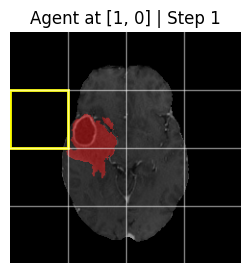

  Step 2: Found tumor at position [1, 1]


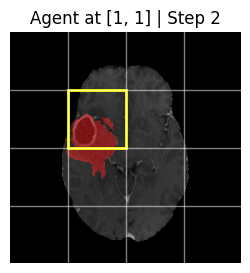

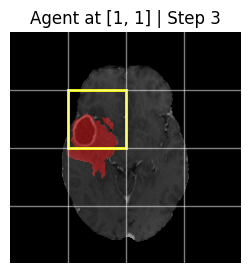

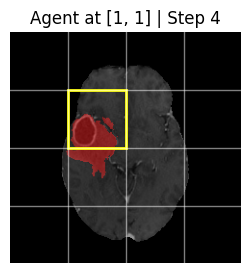

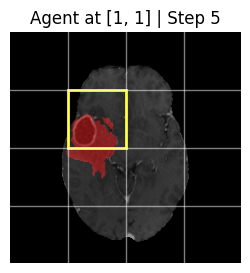

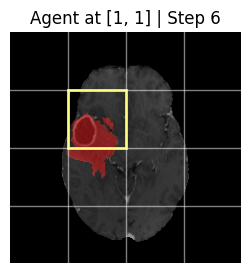

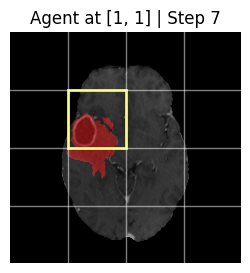

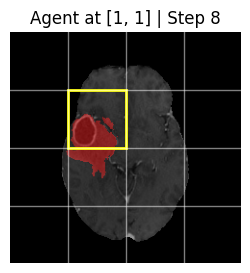

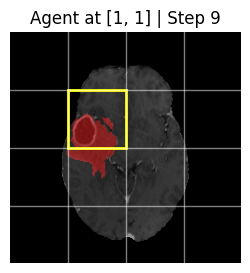

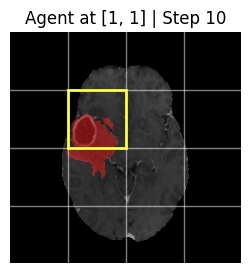

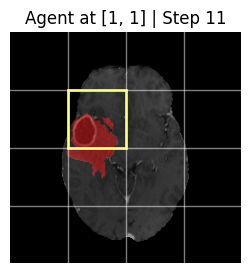

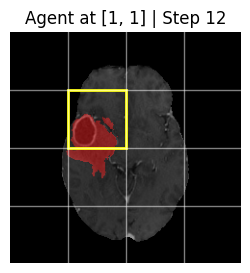

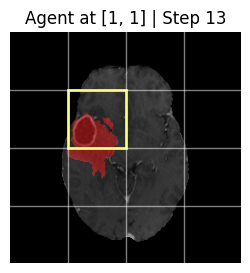

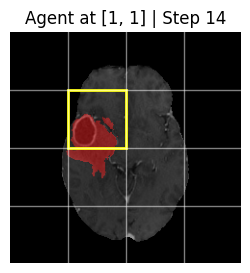

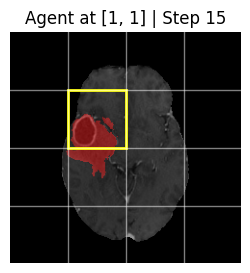

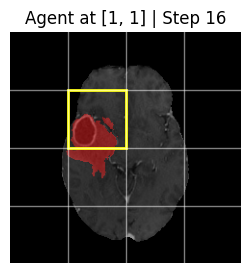

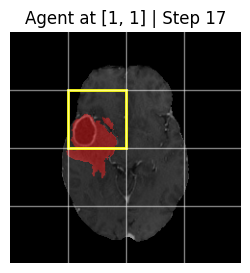

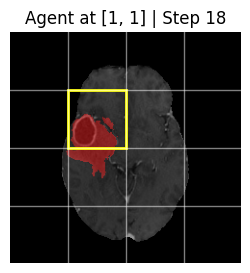

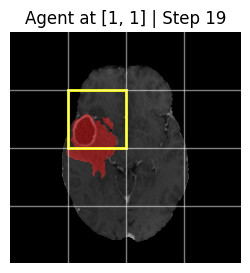

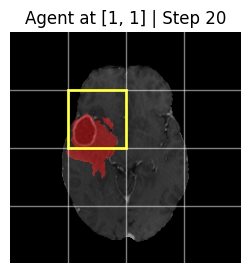

Final position: [1, 1], On tumor: True
Total reward: 18.50

Step-by-step rewards:
  Step 1: Position [1, 0], Reward -0.5
  Step 2: Position [1, 1], Reward 1.0
  Step 3: Position [1, 1], Reward 1.0
  Step 4: Position [1, 1], Reward 1.0
  Step 5: Position [1, 1], Reward 1.0
  Step 6: Position [1, 1], Reward 1.0
  Step 7: Position [1, 1], Reward 1.0
  Step 8: Position [1, 1], Reward 1.0
  Step 9: Position [1, 1], Reward 1.0
  Step 10: Position [1, 1], Reward 1.0
  Step 11: Position [1, 1], Reward 1.0
  Step 12: Position [1, 1], Reward 1.0
  Step 13: Position [1, 1], Reward 1.0
  Step 14: Position [1, 1], Reward 1.0
  Step 15: Position [1, 1], Reward 1.0
  Step 16: Position [1, 1], Reward 1.0
  Step 17: Position [1, 1], Reward 1.0
  Step 18: Position [1, 1], Reward 1.0
  Step 19: Position [1, 1], Reward 1.0
  Step 20: Position [1, 1], Reward 1.0

Visualizing Test Episode 1
Image: 004_87.npy


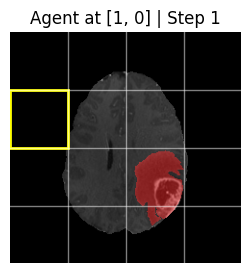

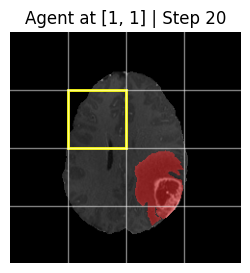

Final position: [1, 1], On tumor: False
Total reward: -37.00

Step-by-step rewards:
  Step 1: Position [1, 0], Reward -0.5
  Step 2: Position [1, 1], Reward -0.5
  Step 3: Position [1, 1], Reward -2.0
  Step 4: Position [1, 1], Reward -2.0
  Step 5: Position [1, 1], Reward -2.0
  Step 6: Position [1, 1], Reward -2.0
  Step 7: Position [1, 1], Reward -2.0
  Step 8: Position [1, 1], Reward -2.0
  Step 9: Position [1, 1], Reward -2.0
  Step 10: Position [1, 1], Reward -2.0
  Step 11: Position [1, 1], Reward -2.0
  Step 12: Position [1, 1], Reward -2.0
  Step 13: Position [1, 1], Reward -2.0
  Step 14: Position [1, 1], Reward -2.0
  Step 15: Position [1, 1], Reward -2.0
  Step 16: Position [1, 1], Reward -2.0
  Step 17: Position [1, 1], Reward -2.0
  Step 18: Position [1, 1], Reward -2.0
  Step 19: Position [1, 1], Reward -2.0
  Step 20: Position [1, 1], Reward -2.0

Visualizing Test Episode 1
Image: 021_96.npy


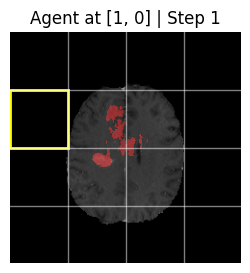

  Step 2: Found tumor at position [1, 1]


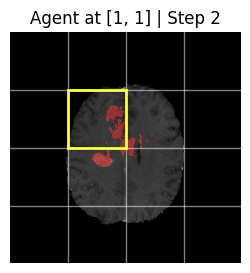

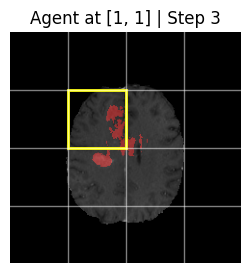

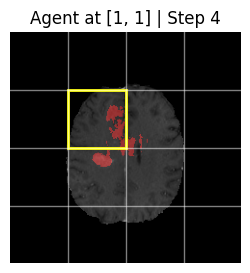

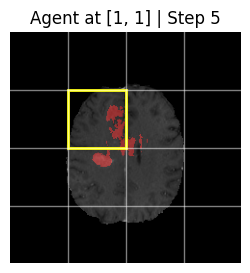

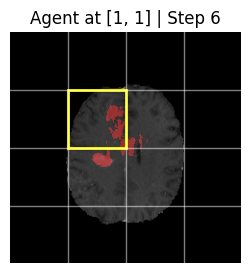

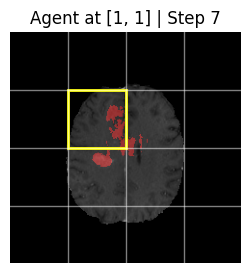

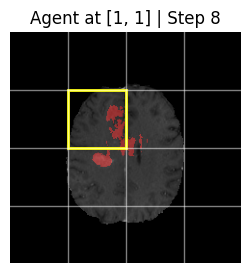

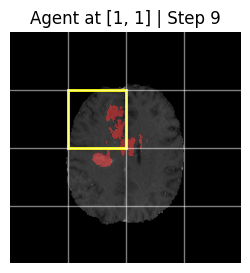

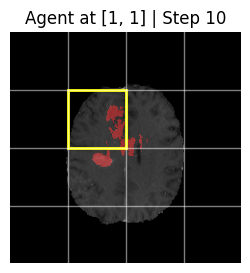

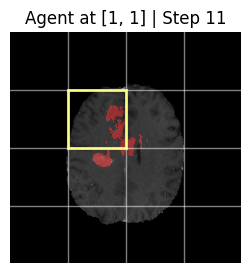

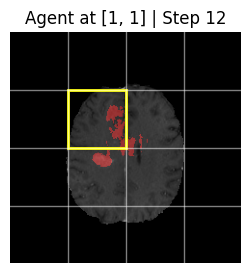

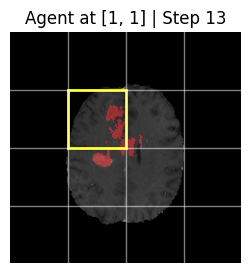

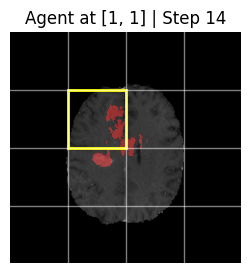

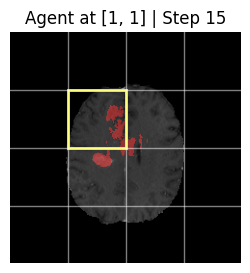

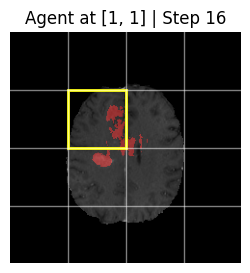

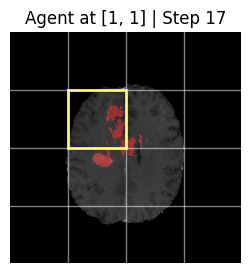

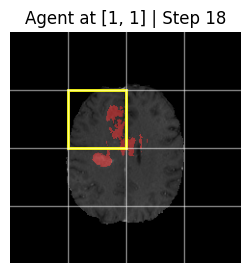

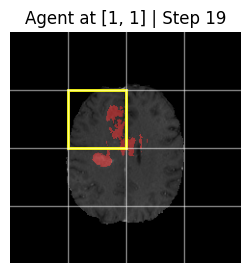

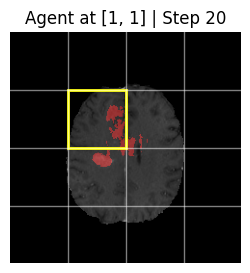

Final position: [1, 1], On tumor: True
Total reward: -37.00

Step-by-step rewards:
  Step 1: Position [1, 0], Reward -0.5
  Step 2: Position [1, 1], Reward -0.5
  Step 3: Position [1, 1], Reward -2.0
  Step 4: Position [1, 1], Reward -2.0
  Step 5: Position [1, 1], Reward -2.0
  Step 6: Position [1, 1], Reward -2.0
  Step 7: Position [1, 1], Reward -2.0
  Step 8: Position [1, 1], Reward -2.0
  Step 9: Position [1, 1], Reward -2.0
  Step 10: Position [1, 1], Reward -2.0
  Step 11: Position [1, 1], Reward -2.0
  Step 12: Position [1, 1], Reward -2.0
  Step 13: Position [1, 1], Reward -2.0
  Step 14: Position [1, 1], Reward -2.0
  Step 15: Position [1, 1], Reward -2.0
  Step 16: Position [1, 1], Reward -2.0
  Step 17: Position [1, 1], Reward -2.0
  Step 18: Position [1, 1], Reward -2.0
  Step 19: Position [1, 1], Reward -2.0
  Step 20: Position [1, 1], Reward -2.0


In [12]:
for i in range(3):  # visualize 3 test episodes
    visualize_test_episode(DQNAgent(
        env=Glioblastoma(*test_pairs[i], grid_size=4),
        dnnetwork=model,
        ReplayBuffer=ReplayBuffer,
        train_pairs=test_pairs,
    epsilon=0.00  # very low epsilon for testing
    ), test_pairs[i][0], test_pairs[i][1], episode_num=1)